In [1]:
import eland as ed
import numpy as np
import os

from elasticsearch import Elasticsearch
from dotenv import load_dotenv

os.chdir("..")
load_dotenv()

True

In [2]:
es_url = os.environ.get('ELASTICSEARCH_URL')
es_api_key = os.environ.get('ELASTICSEARCH_API_KEY')
es = Elasticsearch(hosts=[f"{es_url}"], api_key=es_api_key)

In [3]:
ticker="NVDA"
df_eod = ed.DataFrame(es, es_index_pattern="quant-agents_stocks-eod_*")
df_eod = df_eod[(df_eod.key_ticker == ticker)]
df_sma = ed.eland_to_pandas(df_eod)[::-1].set_index('date_reference')
df_sma['sma_10'] = df_sma['val_close'].rolling(window=10).mean()
df_sma['sma_20'] = df_sma['val_close'].rolling(window=20).mean()

/Users/bsantanna/miniconda3/envs/agent-lab/lib/python3.12/site-packages/eland/common.py:302: Warning: The 'yyyy-MM-dd' format is not explicitly supported.Using pandas.to_datetime(value) to parse value
  warnings.warn(


In [4]:
df_sma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2025-06-03 to 2025-10-23
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key_ticker  100 non-null    object 
 1   val_close   100 non-null    float64
 2   val_high    100 non-null    float64
 3   val_low     100 non-null    float64
 4   val_open    100 non-null    float64
 5   val_volume  100 non-null    int64  
 6   sma_10      91 non-null     float64
 7   sma_20      81 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 7.0+ KB


In [5]:
df_sma.tail()

,key_ticker,val_close,val_high,val_low,val_open,val_volume,sma_10,sma_20
date_reference,,,,,,,,
2025-10-17,NVDA,183.22,184.100,179.7500,180.180,173135217,184.863,183.7850
2025-10-20,NVDA,182.64,185.200,181.7300,183.130,128544711,184.573,183.7365
2025-10-21,NVDA,181.16,182.785,179.8000,182.785,124240168,184.185,183.8730
2025-10-22,NVDA,180.28,183.440,176.7600,181.140,162249552,183.302,184.0385
2025-10-23,NVDA,182.16,183.030,179.7901,180.420,111363718,182.261,184.2620


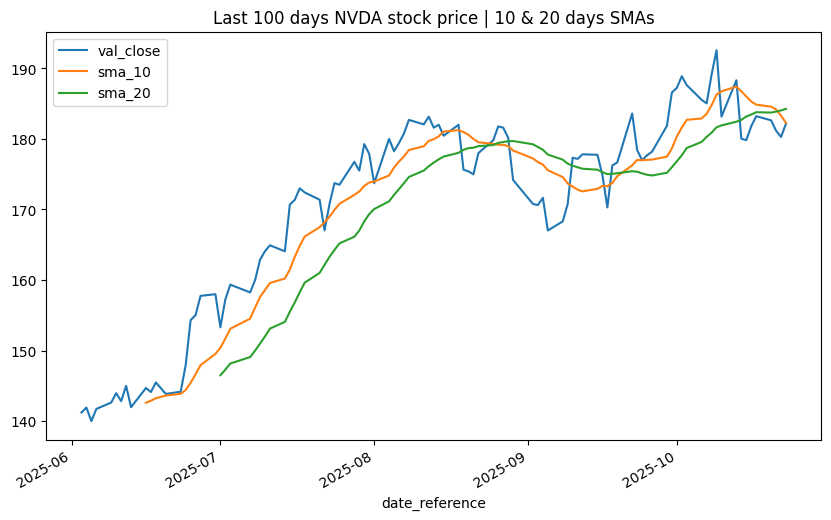

In [6]:
df_sma[["val_close", "sma_10", "sma_20"]].plot(title=f"Last 100 days {ticker} stock price | 10 & 20 days SMAs", figsize=(10, 6));

In [7]:
df_sma['position'] = np.where(df_sma['sma_10'] > df_sma['sma_20'], 1, -1)
df_sma.dropna(inplace=True)

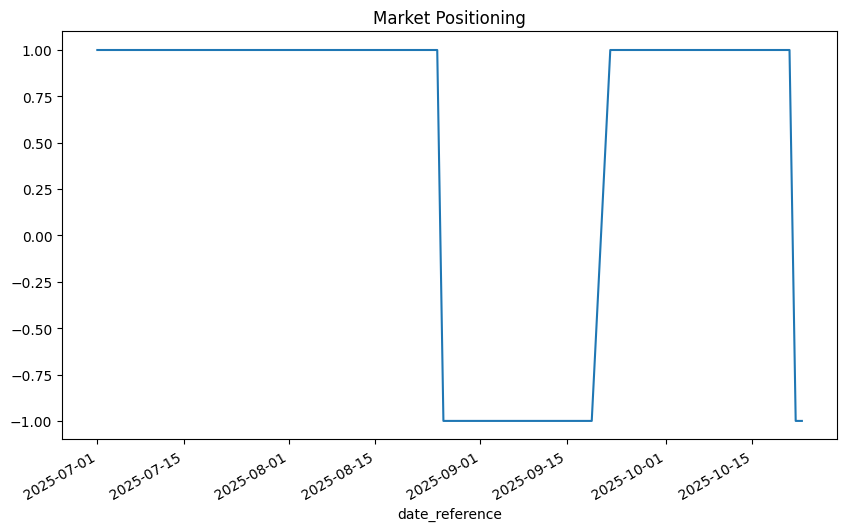

In [8]:
df_sma['position'].plot(
    ylim=[-1.1, 1.1],
    title='Market Positioning',
    figsize=(10, 6)
);

In [9]:
df_sma['returns'] = np.log(df_sma['val_close'] / df_sma['val_close'].shift(1))
df_sma['strategy'] = df_sma['position'].shift(1) * df_sma['returns']
df_sma[['returns', 'strategy']].sum().apply(np.exp)

returns     1.188258
strategy    1.140648
dtype: float64

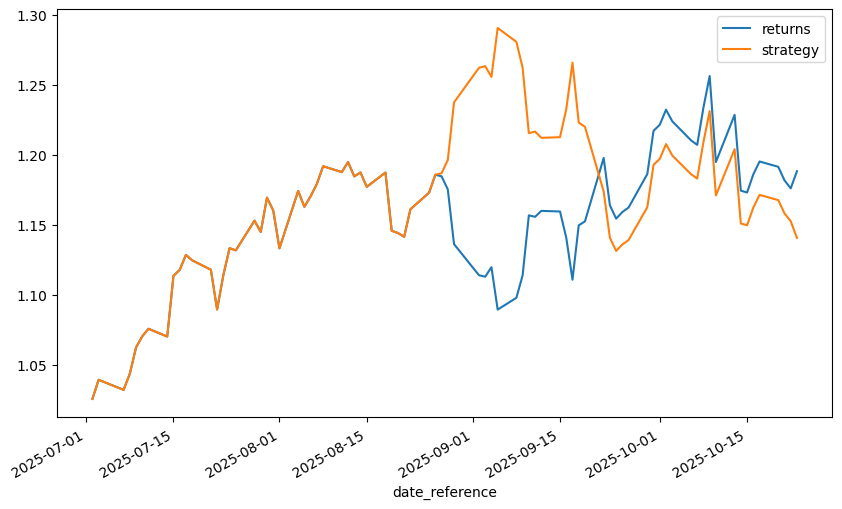

In [10]:
df_sma[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10, 6));